In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

Обработка набора данных

In [2]:
ds = pd.read_csv("../data/Smoker_dataset.csv")

ds = ds.rename(columns = {"type" : "Is smoker?", "Condition" : "Has cancer?"})

ds = ds.dropna()

ds["Has cancer?"] = [1 if elem == "Cancer" else 0 for elem in ds["Has cancer?"]]

genes = ["Gene2337", "Gene35715", "Gene12936", "Gene1689", "FGFR1", "GATA4"]
GOOD = 10.0

for gene in genes:
    ds = ds.loc[abs(ds[gene]) <= GOOD]

Примененяю One-Hot Encoding к категориальному признаку

In [3]:
ds = pd.get_dummies(ds)
ds.head()

,Gene2337,Gene35715,Gene12936,Gene1689,FGFR1,GATA4,Has cancer?,Is smoker?_Nonsmoker,Is smoker?_Smoker
0,-4.750470,-1.518091,6.715013,-1.722331,0.170110,-7.846961,1,0,1
1,-5.183375,0.039654,2.529460,-1.323490,-0.315844,-4.447406,1,0,1
2,1.579079,1.588153,0.569724,-1.229601,-4.119116,0.649277,0,0,1
3,-1.557053,-3.818996,3.798518,-1.204911,1.010464,-6.712354,1,0,1
4,-1.329637,-3.623963,2.722249,-0.784387,1.564218,-5.580853,1,0,1


Разбиваю на признаки и классы

In [4]:
X = ds.drop("Has cancer?", axis = 1).to_numpy()
y = ds["Has cancer?"].to_numpy()

print(X.shape)
print(y.shape)

(1000, 8)
(1000,)


In [5]:
X[:5]

array([[-4.75047047, -1.51809118,  6.71501286, -1.72233072,  0.17011048,
        -7.84696068,  0.        ,  1.        ],
       [-5.18337517,  0.03965445,  2.52946043, -1.32348957, -0.31584364,
        -4.44740644,  0.        ,  1.        ],
       [ 1.57907908,  1.5881532 ,  0.56972429, -1.22960145, -4.11911617,
         0.64927698,  0.        ,  1.        ],
       [-1.55705255, -3.81899603,  3.79851766, -1.20491135,  1.01046375,
        -6.71235373,  0.        ,  1.        ],
       [-1.32963731, -3.6239626 ,  2.72224926, -0.78438661,  1.56421809,
        -5.58085274,  0.        ,  1.        ]])

Нормализую все признаки, чтобы они были в промежутке $[-1, 1]$

In [6]:
from sklearn.preprocessing import normalize
X = normalize(X, norm = "max", axis = 0)

In [7]:
X[:5]

array([[-0.53243755, -0.20069442,  0.94794783, -0.22613268,  0.02647339,
        -0.96918971,  0.        ,  1.        ],
       [-0.58095794,  0.00524239,  0.35707996, -0.173767  , -0.04915306,
        -0.54930574,  0.        ,  1.        ],
       [ 0.17698478,  0.20995675,  0.08042708, -0.16144   , -0.64103609,
         0.08019316,  0.        ,  1.        ],
       [-0.17451603, -0.50487823,  0.53623078, -0.15819832,  0.15725309,
        -0.82905273,  0.        ,  1.        ],
       [-0.1490271 , -0.47909445,  0.38429566, -0.10298571,  0.24343092,
        -0.68929937,  0.        ,  1.        ]])

Разбиваю на обучающую и тестовую выборку

In [8]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.8, random_state = 1, shuffle = True)

print(train_X.shape)
print(train_y.shape)

print(test_X.shape)
print(test_y.shape)

(800, 8)
(800,)
(200, 8)
(200,)


Функция, которая выводит Accuracy, Recall и Precision, рисует Confusion Matrix и ROC-кривую
* Accuracy - число верно угаданных
* Recall - полнота
* Precision - точность

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay

def scores(model, X, y_true):
    y_pred = model.predict(X)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    figure = plt.figure(figsize = (20, 5))
    matr = confusion_matrix(y_true, y_pred)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matr).plot(ax = ax)
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(y_true = y_true, y_pred = y_pred, name = "ROC-кривая", ax = ax)
    plt.show()

Функция, которая печатает результат подбора гиперпараметров модели

In [10]:
def best(model):
    print("Лучшие гиперпараметры модели:", model.best_params_)
    print("Лучший счёт модели:", model.best_score_)

Использую [этот шаблон](https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/_template.py) для реализации классификаторов

## kNN

In [11]:
from sklearn.metrics import euclidean_distances

class kNN(ClassifierMixin, BaseEstimator):
    def __init__(self, k = 1):
        self.k = k

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # Input validation
        X = check_array(X)
        
        y = np.ndarray((X.shape[0],))
        for (i, elem) in enumerate(X):
            distances = euclidean_distances([elem], self.X_)[0]
            neighbors = np.argpartition(distances, kth = self. k - 1)
            k_neighbors = neighbors[:self.k]
            labels, cnts = np.unique(self.y_[k_neighbors], return_counts = True)
            y[i] = labels[cnts.argmax()]
        return y

In [12]:
gscv = GridSearchCV(Pipeline([('knn', kNN())]), {'knn__k' : [1, 3, 5, 7, 9]})
gscv.fit(train_X, train_y)
best(gscv)

Лучшие гиперпараметры модели: {'knn__k': 3}
Лучший счёт модели: 0.9950000000000001


Accuracy: 0.99
Recall: 0.9863013698630136
Precision: 0.9863013698630136


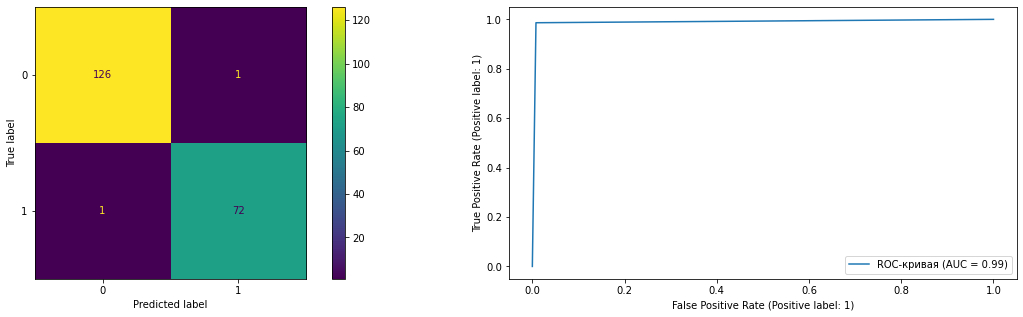

In [13]:
kNN_best = gscv.best_estimator_
scores(kNN_best, test_X, test_y)

In [14]:
f = open("knn.pkl", "wb")
pickle.dump(kNN_best, f, pickle.HIGHEST_PROTOCOL)
f.close()

[kNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) из библиотеки scikit-learn

In [15]:
from sklearn.neighbors import KNeighborsClassifier

gscv = GridSearchCV(Pipeline([('knn', KNeighborsClassifier())]), {'knn__n_neighbors' : [1, 3, 5, 7, 9]})
gscv.fit(train_X, train_y)
best(gscv)

Лучшие гиперпараметры модели: {'knn__n_neighbors': 3}
Лучший счёт модели: 0.9950000000000001


Accuracy: 0.99
Recall: 0.9863013698630136
Precision: 0.9863013698630136


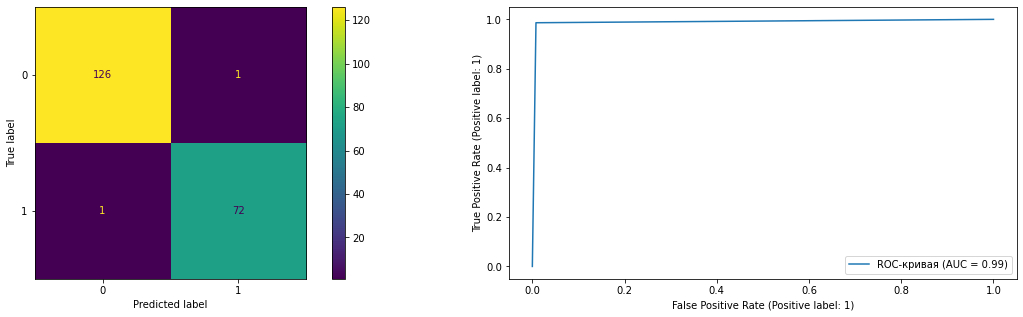

In [16]:
kNN_best = gscv.best_estimator_
scores(kNN_best, test_X, test_y)

## Logistic Regression

Опишу упрощённый класс нейросети, линейного слоя, сигмоиды. За основу взять исходный код из ЛР с персептроном

In [17]:
class Net:
    def __init__(self, loss_function):
        self.layers = []
        self.loss = loss_function()
    
    def append(self, layer):
        self.layers.append(layer)
    
    # Вычисление предсказания
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, z):
        for layer in self.layers[::-1]:
            z = layer.backward(z)
        return z
    
    # Вычисление значения функции потерь
    def forward_loss(self, x, y):
        p = self.forward(x)
        return self.loss.forward(p, y)
    
    def backward_loss(self, l):
        dp = None
        dp = self.loss.backward(l)
        return self.backward(dp)
    
    def update(self, step):
        for layer in self.layers:
            if "update" in layer.__dir__():
                layer.update(step)
    
    # Эпоха обучения на данных x, y
    def train_epoch(self, x, y, batch_size = 100, step = 1e-7):
        for i in range(0, len(x), batch_size):
            xb = x[i:i + batch_size]
            yb = y[i:i + batch_size]

            loss = self.forward_loss(xb, yb)
            dx = self.backward_loss(loss)
            
            self.update(step)

Линейный слой $y = W \cdot x + b$

In [18]:
class Linear:
    def __init__(self, n, m):
        mu = 0.0
        sigma = 1.0 / np.sqrt(2.0 * n)
        self.W = np.random.normal(mu, sigma, (m, n))
        self.b = np.zeros((1, m))
        self.dW = np.zeros((m, n))
        self.db = np.zeros((1, m))
    
    def forward(self, x):
        self.x = x
        z = np.dot(x, self.W.T) + self.b
        return z

    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis = 0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self, step):
        self.W -= step * self.dW
        self.b -= step * self.db

Логистическая функция $\sigma(x) = (1 + e ^ {-x}) ^ {-1}$

In [19]:
class Sigmoid:
    def forward(self, x):
        self.y = 1.0 / (1.0 + np.exp(-x))
        return self.y
    
    def backward(self, dy):
        return self.y * (1.0 - self.y) * dy

Функция потерь

In [20]:
class BinaryCrossEntropy:
    def forward(self, p, y):
        y = y.reshape((y.shape[0], 1))
        self.p = p
        self.y = y
        res = y * np.log(p) + (1 - y) * np.log(1 - p)
        return -np.mean(res)
    
    def backward(self, loss):
        res = (self.p - self.y) / (self.p * (1 - self.p))
        return res / self.p.shape[0]

Сам классификатор

In [21]:
class LogisticRegression(ClassifierMixin, BaseEstimator):
    def __init__(self, epoches = 1, batch_size = 10, SGD_step = 0.001):
        self.epoches = epoches
        self.batch_size = batch_size
        self.SGD_step = SGD_step
        self.Net = Net(BinaryCrossEntropy)
        self.Net.append(Linear(8, 1))
        self.Net.append(Sigmoid())

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        for _ in range(self.epoches):
            self.Net.train_epoch(X, y, self.batch_size, self.SGD_step)
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # Input validation
        X = check_array(X)
        
        y = self.Net.forward(X)
        res = np.where(y < 0.5, 0, 1)
        return res

In [22]:
gscv = GridSearchCV(Pipeline([("logreg", LogisticRegression())]),
                    {"logreg__epoches" : [1, 2, 4],
                     "logreg__batch_size" : [5, 10, 20],
                     "logreg__SGD_step" : [0.01, 0.05, 0.1]})
gscv.fit(train_X, train_y)
best(gscv)

Лучшие гиперпараметры модели: {'logreg__SGD_step': 0.05, 'logreg__batch_size': 5, 'logreg__epoches': 2}
Лучший счёт модели: 0.9950000000000001


Accuracy: 0.99
Recall: 0.9863013698630136
Precision: 0.9863013698630136


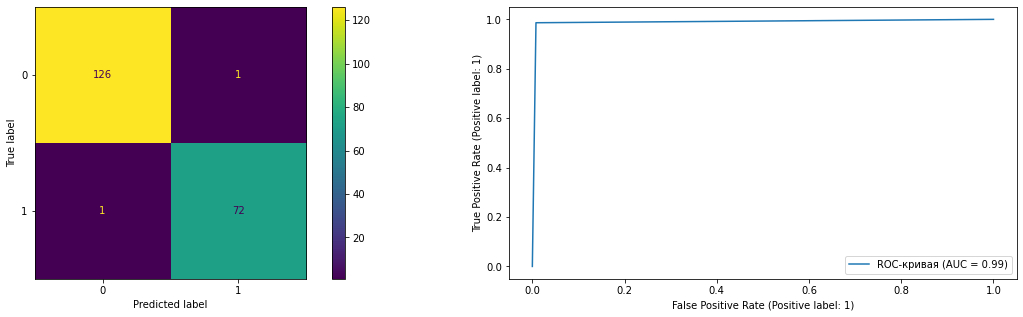

In [23]:
logreg_best = gscv.best_estimator_
scores(logreg_best, test_X, test_y)

In [24]:
rscv = RandomizedSearchCV(Pipeline([("logreg", LogisticRegression())]),
                    {"logreg__epoches" : [1, 2, 4],
                     "logreg__batch_size" : [5, 10, 20],
                     "logreg__SGD_step" : [0.01, 0.05, 0.1]})
rscv.fit(train_X, train_y)
best(rscv)

Лучшие гиперпараметры модели: {'logreg__epoches': 2, 'logreg__batch_size': 10, 'logreg__SGD_step': 0.05}
Лучший счёт модели: 0.9950000000000001


Accuracy: 0.985
Recall: 0.9726027397260274
Precision: 0.9861111111111112


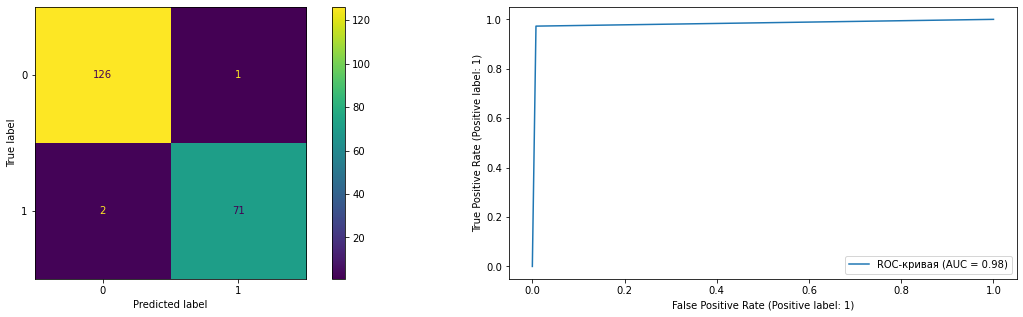

In [25]:
SVM_best = rscv.best_estimator_
scores(SVM_best, test_X, test_y)

In [26]:
f = open("logreg.pkl", "wb")
pickle.dump(logreg_best, f, pickle.HIGHEST_PROTOCOL)
f.close()

[Логистическая регрессия](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из scikit-learn

In [27]:
from sklearn.linear_model import LogisticRegression

gscv = GridSearchCV(Pipeline([("logreg", LogisticRegression())]),
                    {"logreg__penalty" : ["l2", "none"],
                     "logreg__solver" : ["newton-cg", "lbfgs"]})
gscv.fit(train_X, train_y)
best(gscv)

Лучшие гиперпараметры модели: {'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
Лучший счёт модели: 0.9950000000000001


Accuracy: 0.99
Recall: 0.9863013698630136
Precision: 0.9863013698630136


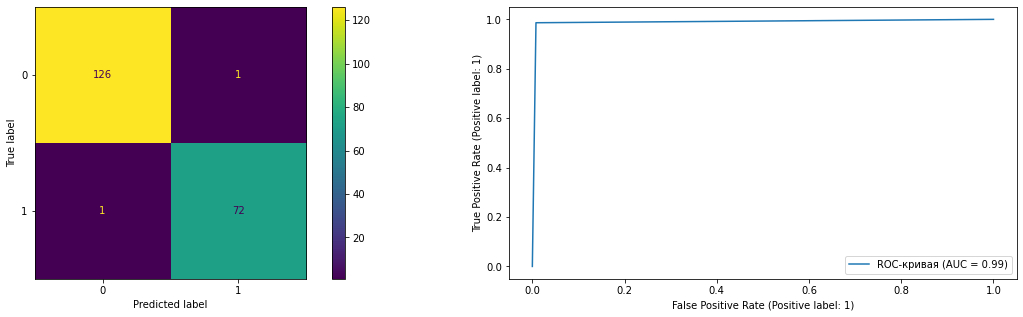

In [28]:
logreg_best = gscv.best_estimator_
scores(logreg_best, test_X, test_y)

## SVM

Отдельный класс, описывающий линейную модель с мягким зазором

In [29]:
class SoftMarginSVM:
    def __init__(self, n, alpha):
        self.alpha = alpha
        mu = 0.0
        sigma = 1.0 / np.sqrt(n)
        self.W = np.random.normal(mu, sigma, (1, n + 1))
    
    def forward(self, x):
        z = np.dot(x, self.W.T)
        return z
    
    # Добавляет столбец из единиц
    def add_ones(self, x):
        ones = np.ones((x.shape[0], 1))
        return np.hstack((x, ones))
    
    def predict(self, x):
        res = self.forward(self.add_ones(x))
        return np.where(res < 0, 0, 1)
    
    def train_epoch(self, x, y, batch_size = 100, step = 1e-7):
        x = self.add_ones(x)
        y = np.where(y > 0, 1, -1)
        for i in range(0, len(x), batch_size):
            xb = x[i:i + batch_size]
            yb = y[i:i + batch_size]

            pred = self.forward(xb)
            grad = self.alpha * self.W
            for i in range(len(xb)):
                if (yb[i] * pred[i] < 1):
                    grad -= yb[i] * xb[i]
            self.W -= step * grad

Сам классификатор

In [30]:
class SVM(ClassifierMixin, BaseEstimator):
    def __init__(self, epoches = 1, batch_size = 10, SGD_step = 0.001, alpha = 0.1):
        self.epoches = epoches
        self.batch_size = batch_size
        self.SGD_step = SGD_step
        self.alpha = alpha
        self.Net = SoftMarginSVM(8, alpha)

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        for _ in range(self.epoches):
            self.Net.train_epoch(X, y, self.batch_size, self.SGD_step)
        # Return the classifier
        return self

    def predict(self, X):
        y = self.Net.predict(X)
        return y

In [31]:
gscv = GridSearchCV(Pipeline([("SVM", SVM())]),
                    {"SVM__epoches" : [1, 2, 4],
                     "SVM__batch_size" : [5, 10, 20],
                     "SVM__SGD_step" : [0.01, 0.05, 0.1],
                     "SVM__alpha" : [1.0, 0.1, 0.01, 0.0]})
gscv.fit(train_X, train_y)
best(gscv)

Лучшие гиперпараметры модели: {'SVM__SGD_step': 0.01, 'SVM__alpha': 1.0, 'SVM__batch_size': 5, 'SVM__epoches': 2}
Лучший счёт модели: 0.9950000000000001


Accuracy: 0.99
Recall: 0.9863013698630136
Precision: 0.9863013698630136


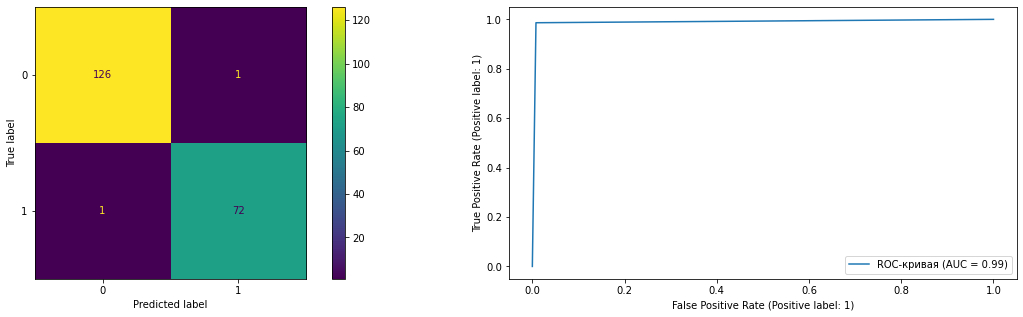

In [32]:
SVM_best = gscv.best_estimator_
scores(SVM_best, test_X, test_y)

In [33]:
rscv = RandomizedSearchCV(Pipeline([("SVM", SVM())]),
                    {"SVM__epoches" : [1, 2, 4],
                     "SVM__batch_size" : [5, 10, 20],
                     "SVM__SGD_step" : [0.01, 0.05, 0.1],
                     "SVM__alpha" : [1.0, 0.1, 0.01, 0.0]})
rscv.fit(train_X, train_y)
best(rscv)

Лучшие гиперпараметры модели: {'SVM__epoches': 1, 'SVM__batch_size': 5, 'SVM__alpha': 0.1, 'SVM__SGD_step': 0.1}
Лучший счёт модели: 0.9950000000000001


Accuracy: 0.99
Recall: 0.9863013698630136
Precision: 0.9863013698630136


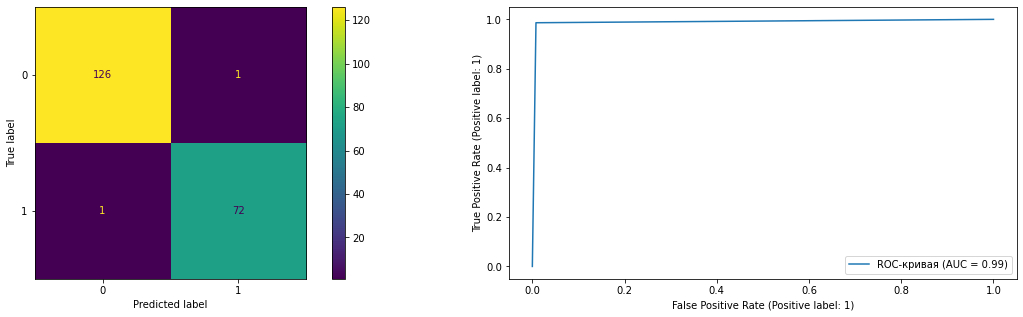

In [34]:
SVM_best = rscv.best_estimator_
scores(SVM_best, test_X, test_y)

In [35]:
f = open("SVM.pkl", "wb")
pickle.dump(SVM_best, f, pickle.HIGHEST_PROTOCOL)
f.close()

[SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) из scikit-learn

In [36]:
from sklearn.svm import SVC

gscv = GridSearchCV(Pipeline([("svc", SVC())]),
                    {'svc__kernel': ["poly", "linear", "rbf"]})
gscv.fit(train_X, train_y)
best(gscv)

Лучшие гиперпараметры модели: {'svc__kernel': 'poly'}
Лучший счёт модели: 0.9950000000000001


Accuracy: 0.99
Recall: 0.9863013698630136
Precision: 0.9863013698630136


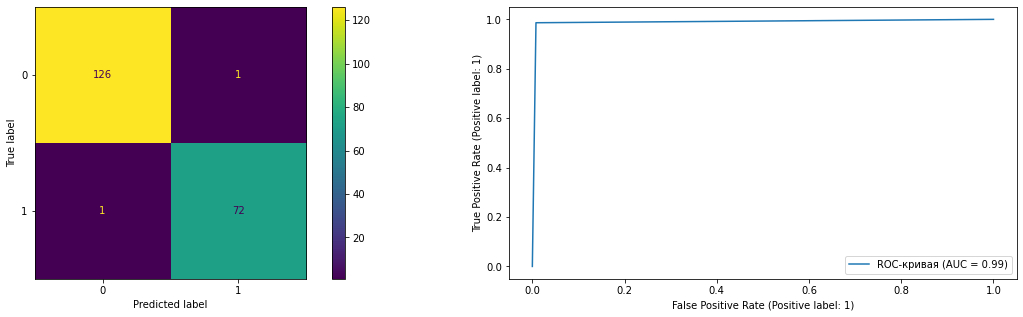

In [37]:
SVM_best = gscv.best_estimator_
scores(SVM_best, test_X, test_y)

## Naive Bayes

Использую нормальное распределение для всех числовых признаков

In [38]:
from math import pi

class NaiveBayes(ClassifierMixin, BaseEstimator):
    def __init__(self):
        None

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        self.X_ = X
        self.y_ = y
        
        labels, cnts = np.unique(self.y_, return_counts = True)
        self.labels = labels
        self.p_of_y = np.array([elem / self.y_.shape[0] for elem in cnts])
        self.means = np.array([self.X_[self.y_ == elem].mean(axis = 0) for elem in labels])
        self.stds = np.array([self.X_[self.y_ == elem].std(axis = 0) for elem in labels])
        # Return the classifier
        return self

    def gaussian(self, mu, sigma, x0):
        return np.exp(-(x0 - mu) ** 2 / (2 * sigma)) / np.sqrt(2.0 * pi * sigma)
    
    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)
        
        res = np.zeros(X.shape[0])
        for (i, elem) in enumerate(X):
            p = np.array(self.p_of_y)
            for (j, label) in enumerate(self.labels):
                p_x_cond_y = np.array([self.gaussian(self.means[j][k], self.stds[j][k], elem[k]) for k in range(X.shape[1])])
                p[j] *= np.prod(p_x_cond_y)
            res[i] = np.argmax(p)
        return res

Accuracy: 0.99
Recall: 0.9863013698630136
Precision: 0.9863013698630136


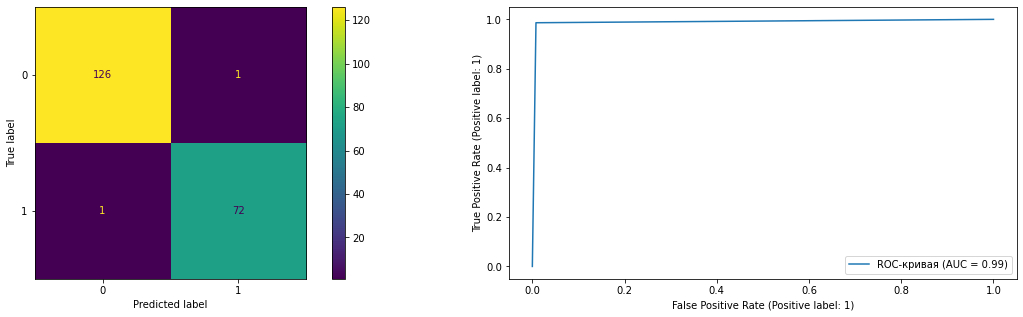

In [39]:
NB = Pipeline([("NB", NaiveBayes())])
NB.fit(train_X, train_y)
scores(NB, test_X, test_y)

In [40]:
f = open("NB.pkl", "wb")
pickle.dump(NB, f, pickle.HIGHEST_PROTOCOL)
f.close()

[Наивный байесовский классификатор](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) из scikit-learn

Accuracy: 0.99
Recall: 0.9863013698630136
Precision: 0.9863013698630136


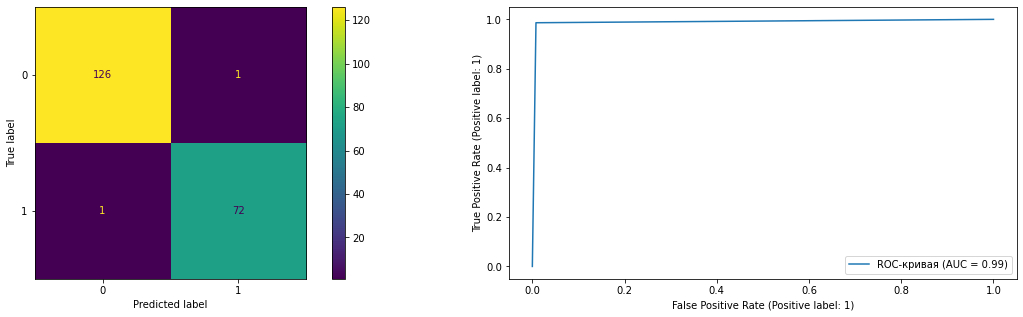

In [41]:
from sklearn.naive_bayes import GaussianNB

NB = Pipeline([("NB", GaussianNB())])
NB.fit(train_X, train_y)
scores(NB, test_X, test_y)